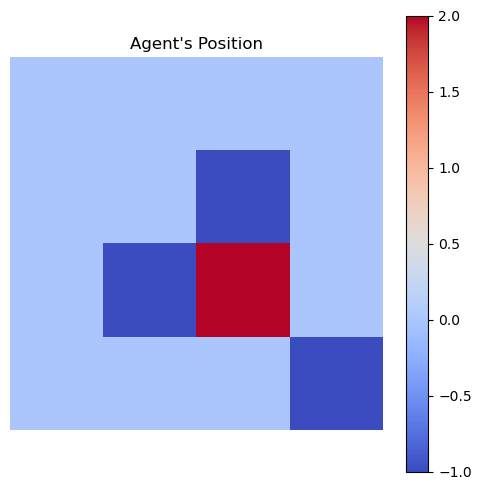

Episode 5 finished with total reward: 100.0
GIF saved to agent_episode_5.gif



In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import configparser
from PIL import Image

# Read configuration from ini file
def read_config(file_path):
    config = configparser.ConfigParser()
    config.read(file_path)
    
    holes = [tuple(map(int, pos.split(','))) for pos in config['environment']['holes'].split(';')]
    goal = tuple(map(int, config['environment']['goal'].split(',')))
    rewards = list(map(int, config['environment']['rewards'].split(',')))
    discount_factor = float(config['environment']['discount_factor'])
    episodes = int(config['environment']['episodes'])
    
    return holes, goal, rewards, discount_factor, episodes

# Custom Environment Class for Goal vs Hole
class GoalVsHoleEnv(gym.Env):
    def __init__(self, holes, goal, rewards):
        super(GoalVsHoleEnv, self).__init__()
        
        # Define action space (4 possible moves: up, down, left, right)
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right
        
        # Define state space (16 cells in the grid)
        self.observation_space = spaces.Discrete(16)

        # Set terminal states (holes and goal)
        self.holes = holes
        self.goal = goal

        # Rewards: 0 for empty, specific values for holes and goal
        self.rewards = np.zeros((4, 4))
        for hole in self.holes:
            self.rewards[hole] = rewards[1]  # Hole reward
        self.rewards[self.goal] = rewards[0]  # Goal reward

        # Start position
        self.start = (0, 0)
        self.agent_pos = self.start

    def reset(self):
        """Reset the environment to the initial state."""
        self.agent_pos = self.start
        return self._get_state()

    def step(self, action):
        """Apply action to move agent and return the result."""
        # Determine next position
        x, y = self.agent_pos
        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(3, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(3, y + 1)
        
        self.agent_pos = (x, y)
        done = self._is_terminal(self.agent_pos)
        reward = self.rewards[self.agent_pos]

        return self._get_state(), reward, done, {}

    def _get_state(self):
        """Convert agent position to a state number (0 to 15)."""
        x, y = self.agent_pos
        return x * 4 + y

    def _is_terminal(self, position):
        """Check if the agent is in a terminal state."""
        return position in self.holes or position == self.goal

    def render(self):
        """Render the current state of the environment."""
        grid_copy = np.zeros((4, 4))
        grid_copy[self.agent_pos] = 1  # Mark the agent's current position
        for hole in self.holes:
            grid_copy[hole] = -1
        grid_copy[self.goal] = 2
        
        plt.imshow(grid_copy, cmap='coolwarm', interpolation='nearest')
        plt.title("Agent's Position")
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Q-learning Agent Training
def train_agent(env, episodes=1000, gamma=0.9, alpha=0.1, epsilon=0.1):
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore action space
            else:
                action = np.argmax(q_table[state])  # Exploit learned values

            next_state, reward, done, _ = env.step(action)
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            # Update Q-value using the Bellman equation
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            state = next_state

    return q_table

# Visualize Agent Running Multiple Episodes and Save GIF
def run_agent(env, q_table, episodes=5):
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        
        # List to store frames for GIF
        frames = []

        print(f"Episode {episode + 1}:\n")
        time.sleep(1)  # Pause before starting the episode
        
        while not done:
            action = np.argmax(q_table[state])  # Choose the best action from Q-table
            state, reward, done, _ = env.step(action)
            total_reward += reward
            
            # Capture the frame
            clear_output(wait=True)
            plt.figure(figsize=(5, 5))  # Set figure size for better visibility
            env.render()
            plt.savefig(f'frame_{episode}.png')  # Save frame as PNG
            plt.close()  # Close the plot to free memory
            frames.append(Image.open(f'frame_{episode}.png'))  # Read saved frame
            
            time.sleep(1)  # Pause for 1 second between steps

        # Create a GIF from the frames using PIL
        gif_path = f'agent_episode_{episode + 1}.gif'
        frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)  # Save as GIF
        print(f"Episode {episode + 1} finished with total reward: {total_reward}\nGIF saved to {gif_path}\n")

# Main Code Execution
if __name__ == "__main__":
    # Read the configuration file
    holes, goal, rewards, discount_factor, episodes = read_config('env.ini')

    env = GoalVsHoleEnv(holes, goal, rewards)

    print("Training agent...")
    q_table = train_agent(env, episodes=episodes, gamma=discount_factor, alpha=0.1, epsilon=0.1)
    print("Training complete!\n")

    print("Running agent on the environment...")
    run_agent(env, q_table, episodes=5)


In [3]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
